In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2024/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2024


In [2]:
!pip install pyspark

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").appName("DataFrame").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=972309b54d74070ad528ff15ae0992a61c47214e4a2e4a979cac1440eee28640
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

pd.set_option('display.max_columns', 500)

import dateutil
from math import radians
from IPython.display import Video

import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sqrt

In [4]:
# tracking = pd.read_csv("./clean_tracking.csv")
tracking = spark.read.option("header",'True').csv("./clean_tracking.csv")
tackle = pd.read_csv('./nfl-big-data-bowl-2024/tackles.csv')
games = pd.read_csv('./nfl-big-data-bowl-2024/games.csv')
plays = pd.read_csv('./nfl-big-data-bowl-2024/plays.csv')

In [ ]:
# tracking.shape
# print((tracking.count(), len(tracking.columns)))

In [ ]:
tracking.show(5)

+---+----------+------+-------+--------------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+------------+-------------+----------------------+--------------------+-------+----+---------+--------------+-------------+------------+--------------+---------+----------------+-------------------+----------+----------+------------+--------------------+----------+----------------------+----------------------+----------------+-----------------+---------------+-----------------------------+--------------------------------+---------------------------+----------------------------+--------------+-------------------+---------+---------+----------+----------+-----------+------+------------------+------------------+-------------------+-------------------+------------------+
|_c0|    gameId|playId|  nflId|   displayName|frameId|                time|jerseyNumber|club|playDirection|    x|    y|   s|   a| dis|     o|   dir|       event|ballCarrierId|b

# Tackles by Week

Let's see if tackles are consistent week-to-week. If not, then we should find a better way to measure a player's tackling ability that is more predictive of future tackling ability.

Create a graph to show tackles in week n and week n+1

In [ ]:
tackle.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [5]:
# tackle for each player by game
tackles_game = tackle.groupby(by=['gameId','nflId']).sum()[['tackle']].reset_index()
tackles_game.head()

,gameId,nflId,tackle
0,2022090800,37075,2
1,2022090800,38577,4
2,2022090800,40107,2
3,2022090800,40166,2
4,2022090800,41341,1


In [6]:
tackles_week = tackles_game.merge(games[['gameId','week']], how='left', on='gameId')
tackles_week['next_week'] = tackles_week['week']+1
tackles_week.head()

,gameId,nflId,tackle,week,next_week
0,2022090800,37075,2,1,2
1,2022090800,38577,4,1,2
2,2022090800,40107,2,1,2
3,2022090800,40166,2,1,2
4,2022090800,41341,1,1,2


In [7]:
tackle_comp = tackles_week.merge(tackles_week[['nflId', 'week', 'tackle']],
                                 how='left', left_on=['nflId','next_week'],
                                 right_on=['nflId','week'],
                                 suffixes=['_current', '_next'])[['nflId','tackle_current','tackle_next']]
tackle_comp.head()

,nflId,tackle_current,tackle_next
0,37075,2,1.0
1,38577,4,2.0
2,40107,2,2.0
3,40166,2,3.0
4,41341,1,1.0


In [8]:
tackle_comp = tackle_comp[(tackle_comp['tackle_current']>0) & (tackle_comp['tackle_next']>0)]

0.31105260292917497


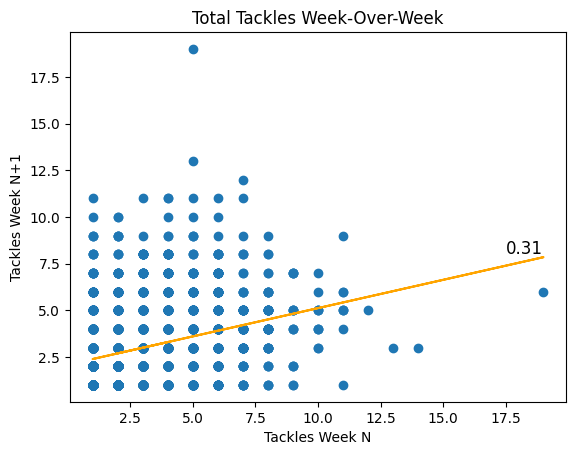

In [9]:
print(tackle_comp.corr()['tackle_current'][2])
# plt.scatter(data=tackle_comp, x='tackle_current', y='tackle_next')
plt.scatter(x=tackle_comp['tackle_current'], y=tackle_comp['tackle_next'])
correlation = tackle_comp.corr()['tackle_current'][2].round(2)

#obtain m (slope) and b(intercept) of linear regression line
x = tackle_comp['tackle_current']
y = tackle_comp['tackle_next']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

plt.text(17.5, 8, correlation, fontsize = 12)

plt.xlabel('Tackles Week N')
plt.ylabel('Tackles Week N+1')
plt.title( 'Total Tackles Week-Over-Week' )

# plt.show()
plt.savefig('./tacklescorr.png')

# Tackle Example

In [ ]:
tackle[(tackle['gameId']==2022090800) & (tackle['playId']==101)]

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0


In [ ]:
tackle_ad = tracking[(tracking['gameId']==2022090800) & ((tracking['nflId']==42816)|(tracking['nflId']==47857)|(tracking['nflId']==41239)) & (tracking['playId']==101) & (tracking['frameId']<=45)]
tackle_ad.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,isOnOffense,ToLeft,X_std,Y_std,abs_x,dir_std,o_std
1294,1294,2022090800,101,41239.0,Aaron Donald,1,2022-09-08 20:25:08.200000,99.0,LA,left,71.28,26.41,0.04,0.05,0.00,62.55,98.32,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.72,26.923333,0.72,-81.68,242.55
1295,1295,2022090800,101,41239.0,Aaron Donald,2,2022-09-08 20:25:08.299999,99.0,LA,left,71.29,26.41,0.04,0.04,0.01,60.23,99.03,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.71,26.923333,0.71,-80.97,240.23
1296,1296,2022090800,101,41239.0,Aaron Donald,3,2022-09-08 20:25:08.400000,99.0,LA,left,71.29,26.41,0.03,0.04,0.00,60.23,98.47,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.71,26.923333,0.71,-81.53,240.23
1297,1297,2022090800,101,41239.0,Aaron Donald,4,2022-09-08 20:25:08.500000,99.0,LA,left,71.29,26.41,0.03,0.04,0.00,60.23,98.26,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.71,26.923333,0.71,-81.74,240.23
1298,1298,2022090800,101,41239.0,Aaron Donald,5,2022-09-08 20:25:08.599999,99.0,LA,left,71.29,26.42,0.03,0.03,0.01,61.59,96.98,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.71,26.913333,0.71,-83.02,241.59


In [ ]:
tackle_ad[tackle_ad['event']=='tackle']

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,isOnOffense,ToLeft,X_std,Y_std,abs_x,dir_std,o_std
1338,1338,2022090800,101,41239.0,Aaron Donald,45,2022-09-08 20:25:12.599999,99.0,LA,left,76.26,39.77,2.89,2.61,0.31,354.54,36.88,tackle,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,43.74,13.563333,-4.26,216.88,174.54
1436,1436,2022090800,101,42816.0,Troy Hill,45,2022-09-08 20:25:12.599999,2.0,LA,left,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,50.92,13.833333,2.92,18.30,30.96
1828,1828,2022090800,101,47857.0,Devin Singletary,45,2022-09-08 20:25:12.599999,26.0,BUF,left,66.69,40.15,4.74,3.88,0.49,218.73,251.22,tackle,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,True,True,53.31,13.183333,5.31,71.22,38.73


In [ ]:
tackle_ad[tackle_ad['frameId']==1]

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,isOnOffense,ToLeft,X_std,Y_std,abs_x,dir_std,o_std
1294,1294,2022090800,101,41239.0,Aaron Donald,1,2022-09-08 20:25:08.200000,99.0,LA,left,71.28,26.41,0.04,0.05,0.00,62.55,98.32,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,48.72,26.923333,0.72,-81.68,242.55
1392,1392,2022090800,101,42816.0,Troy Hill,1,2022-09-08 20:25:08.200000,2.0,LA,left,64.67,40.76,0.06,0.55,0.01,112.17,108.97,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,False,True,55.33,12.573333,7.33,-71.03,-67.83
1784,1784,2022090800,101,47857.0,Devin Singletary,1,2022-09-08 20:25:08.200000,26.0,BUF,left,79.61,29.56,0.00,0.00,0.00,265.65,255.74,NaN,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,BUF,38,13:54,0,0,NaN,NaN,NaN,7,7,N,72,I_FORM,6.0,0.631819,0.399819,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,True,True,40.39,23.773333,-7.61,75.74,85.65


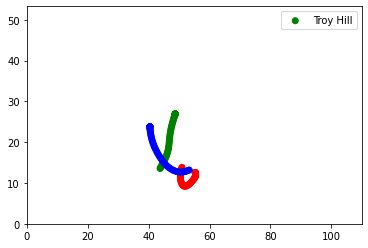

In [ ]:
colors = {'Troy Hill':'red','Devin Singletary':'blue','Aaron Donald':'green'}
plt.scatter(data=tackle_ad, x='X_std', y='Y_std', c=tackle_ad['displayName'].map(colors))
plt.xlim(0,110)
plt.ylim(0,53.3)
plt.legend(['Troy Hill','Devin Singletary','Aaron Donald'])

## Tracking Pursuit Angle throughout the Play

In [ ]:
tackle_ad = tackle_ad.merge(tackle_ad[['gameId','playId','frameId','nflId','X_std','Y_std','abs_x','dir']],
                how='left',
                left_on=['gameId','playId','frameId','ballCarrierId'],
                right_on=['gameId','playId','frameId','nflId'],
               suffixes=['','_carrier'])[['gameId','playId','nflId','displayName','frameId','X_std','Y_std','abs_x','dir','s',
                                          'nflId_carrier','X_std_carrier','Y_std_carrier','abs_x_carrier','dir_carrier',
                                         'club','defensiveTeam']]
tackle_ad.head()

,gameId,playId,nflId,displayName,frameId,X_std,Y_std,abs_x,dir,s,nflId_carrier,X_std_carrier,Y_std_carrier,abs_x_carrier,dir_carrier,club,defensiveTeam
0,2022090800,101,41239.0,Aaron Donald,1,48.72,26.923333,0.72,98.32,0.04,47857.0,40.39,23.773333,-7.61,255.74,LA,LA
1,2022090800,101,41239.0,Aaron Donald,2,48.71,26.923333,0.71,99.03,0.04,47857.0,40.40,23.773333,-7.60,258.97,LA,LA
2,2022090800,101,41239.0,Aaron Donald,3,48.71,26.923333,0.71,98.47,0.03,47857.0,40.40,23.773333,-7.60,259.87,LA,LA
3,2022090800,101,41239.0,Aaron Donald,4,48.71,26.923333,0.71,98.26,0.03,47857.0,40.40,23.773333,-7.60,259.74,LA,LA
4,2022090800,101,41239.0,Aaron Donald,5,48.71,26.913333,0.71,96.98,0.03,47857.0,40.40,23.773333,-7.60,263.81,LA,LA


In [ ]:
tackle_ad['pursuit_angle'] = abs(tackle_ad['dir_carrier'] - tackle_ad['dir'])

In [ ]:
tackle_ad[tackle_ad['frameId']==1]['Y_std']

0     26.923333
45    12.573333
90    23.773333
Name: Y_std, dtype: float64

In [ ]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')

    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

In [ ]:
def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy

def animate_player_movement(weekNumber, playId, gameId):
    weekData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/tracking_week_' + str(weekNumber) + '.csv')
    playData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/plays.csv')

    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "BUF"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "LA"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "football"')

    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')

    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())

    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()

    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber

    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo

    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')

    def update_animation(time):
        patch = []

        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(homeX), np.array(homeY), 'o',c='gold', ms=20, mec='white'))

        # Home players' jersey number
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))

        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))

        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(awayX), np.array(awayY), 'o',c='orangered', ms=20, mec='white'))

        # Away players' jersey number
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))

        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))

        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(np.array(footballX), np.array(footballY), 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['club']))


        return patch

    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)

    anim = animation.ArtistAnimation(fig, ims, repeat=True)

    return anim

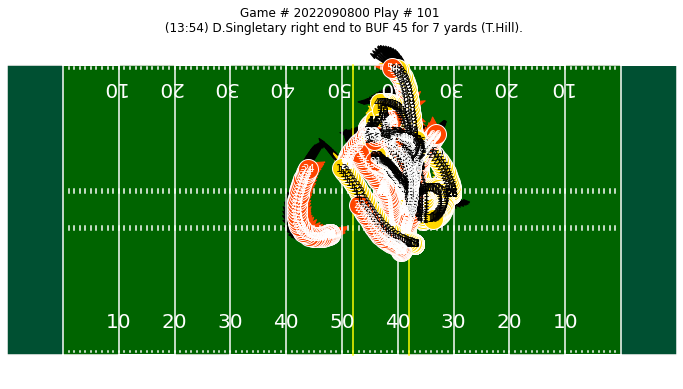

In [ ]:
anim = animate_player_movement(1, 101, 2022090800)

In [ ]:
writer = FFMpegWriter(fps=10)
anim.save('animation_notrail.mp4', writer=writer)

In [ ]:
Video("animation_notrail.mp4")

The directions are shown by the black arrows coming from the player's dot. We can't use this as the pursuit angle because it doesn't take into account the ball carrier. Therefore, we must create an equation for pursuit angle.

Take a couple players from this play and show that animation. Then take one frame and show how we plan to use pursuit angle as the difference of defender direction and ball carrier direction.

I'll take the player who made the tackle and Aaron Donald and plot them with the ball carrier to showcase the direction and further prove our formula.

In [ ]:
tracking['time'].unique()[10]

'2022-09-08 20:24:06.200000'

In [ ]:
def animate_player_movement_select_players(weekNumber, playId, gameId, nflId_home, nflId_away):
    weekData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/tracking_week_' + str(weekNumber) + '.csv')
    playData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/plays.csv')

    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "BUF"' + 'and nflId ==' + str(nflId_home))
    #playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "LA"')
    playAway = tracking[(tracking['gameId']==gameId) & (tracking['playId']==playId) & (tracking['club']=='LA') & (tracking['nflId'].isin(nflId_away))]
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "football"')

    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')

    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())

    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()

    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber

    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo

    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')

    def update_animation(time):
        patch = []

        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(homeX), np.array(homeY), 'o',c='gold', ms=20, mec='white'))

        # Home players' jersey number
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))

        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))

        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(awayX), np.array(awayY), 'o',c='orangered', ms=20, mec='white'))
        plt.title(f'Game # {gameId} Play # {playId} \n {playDesc} {time}')


        # Away players' jersey number
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))

        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))

        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(np.array(footballX), np.array(footballY), 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['club']))


        return patch

    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)

    anim = animation.ArtistAnimation(fig, ims, repeat=True)

    return anim

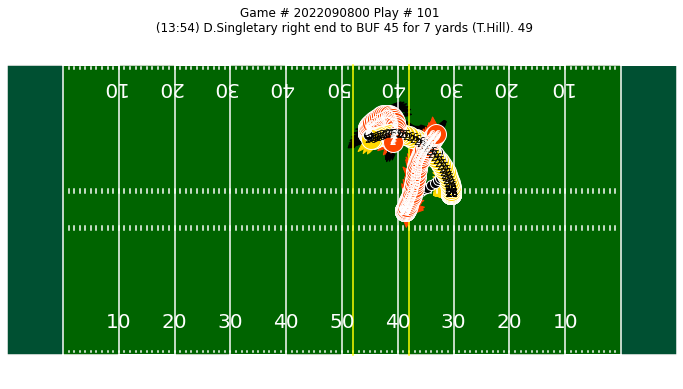

In [ ]:
anim = animate_player_movement_select_players(1, 101, 2022090800, 47857,[41239,42816])

In [ ]:
writer = FFMpegWriter(fps=10)
anim.save('animation_notrail_player_sample.mp4', writer=writer)

In [ ]:
Video("animation_notrail_player_sample.mp4")

Let's take a look at a single frame to setup the formula.

In [ ]:
def animate_player_movement_select_players_frame(weekNumber, playId, gameId, nflId_home, nflId_away):
    weekData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/tracking_week_' + str(weekNumber) + '.csv')
    playData = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/plays.csv')

    #playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "BUF"' + 'and nflId ==' + str(nflId_home))
    playHome = tracking[(tracking['gameId']==gameId) &
                        (tracking['playId']==playId) &
                        (tracking['club']=='BUF') &
                        (tracking['nflId'].isin(nflId_home)) &
                       (tracking['frameId']==30)]
    #playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "LA"')
    playAway = tracking[(tracking['gameId']==gameId) &
                        (tracking['playId']==playId) &
                        (tracking['club']=='LA') &
                        (tracking['nflId'].isin(nflId_away)) &
                       (tracking['frameId']==30)]
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and club == "football"')

    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')

    maxTime = int(playAway['time'].unique().max())

    minTime = int(playAway['time'].unique().min())

    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()

    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber

    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo

    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')

    def update_animation(time):
        patch = []

        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(homeX), np.array(homeY), 'o',c='gold', ms=20, mec='white'))

        # Home players' jersey number
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))

        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))

        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        #patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        patch.extend(plt.plot(np.array(awayX), np.array(awayY), 'o',c='orangered', ms=20, mec='white'))

        # Away players' jersey number
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))

        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))

        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))

        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(np.array(footballX), np.array(footballY), 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['club']))


        return patch

    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)

    anim = animation.ArtistAnimation(fig, ims, repeat=True)

    return anim

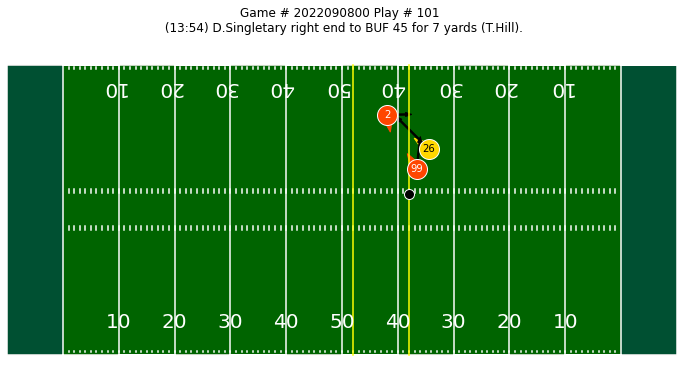

In [ ]:
anim = animate_player_movement_select_players_frame(1, 101, 2022090800, [47857],[41239,42816])

This frame is a good example of why direction can't be used. Hill is moving at about 90 degrees; however, this doesn't mean that he's running perpendicular to the ball carrier.